In [1]:
import xarray as xr
import numpy as np 
import os
import types
import matplotlib.pyplot as plt
import pandas as pd

from src.utils import util_cesm
from src import config_cesm
from src.models import models_util

reference_grid = util_cesm.generate_sps_grid()

def load_globals(module):
    """
    Load all global variables declared in a module as a dictionary.
    
    Parameters:
        module (module): The loaded Python module.
    
    Returns:
        dict: A dictionary containing global variables from the module.
    """
    return {
        name: value
        for name, value in vars(module).items()
        if not name.startswith("__") and not isinstance(value, types.ModuleType) and not callable(value)
    }

def get_ensemble_members_and_time_coords(data_split_settings, split):
    if data_split_settings["split_by"] == "ensemble_member":
        ensemble_members = data_split_settings[split]
        time_coords = data_split_settings["time_range"]
    elif data_split_settings["split_by"] == "time":
        ensemble_members = data_split_settings["member_ids"]
        time_coords = data_split_settings[split]

    return ensemble_members, time_coords


def broadcast_climatology_like(data_split_settings, da):
    """
    Param:
        dict            this should have the name of the data_settings which specifies the climatology 
        xr.DataArray    prediction-like array that you want to broadcast climatology 
    
    Returns:
        xr.DataArray    climatology broadcasted
    """

    icefrac_mean = xr.open_dataset(f"{config_cesm.PROCESSED_DATA_DIRECTORY}/normalized_inputs/{data_split_settings["name"]}/icefrac_mean.nc").icefrac
    
    def calculate_month(start_month, lead_time):
        return (start_month + lead_time - 2) % 12 + 1

    pred_months = xr.apply_ufunc(
        calculate_month,
        da["start_prediction_month"].dt.month,
        da["lead_time"],
        vectorize=True,
        dask="allowed",
        output_dtypes=[int],
    )

    climatology_broadcasted = icefrac_mean.sel(month=pred_months).broadcast_like(da).drop_vars("month")

    return climatology_broadcasted


def add_climatology(da, climatology_broadcasted, clip=True):
    """
    Param:
        (xr.DataArray)  array of anomalies
        (xr.DataArray)  array of climatology that is the same shape as da
                        note: to do this you can run broadcast_climatology_like
        (bool)          possibly clip the anomalies to 

    Returns:
        (xr.DataArray)
    """
    # Add climatology back to the anomalies
    absolute_da = da + climatology_broadcasted

    # Clip the resulting values to [0, 1]
    if clip: absolute_da = absolute_da.clip(0, 1)

    return absolute_da

def remove_climatology(da, climatology_broadcasted):
    return da - climatology_broadcasted


def load_model_predictions(config, nn_ens_avg=True, climatology_broadcasted=None, add_climatology_to_anomaly=True):
    """
    If the config specifies that the predictions are anomalies, then the climatology is added back
    WITH clipping of unphysical values (e.g., if anomaly prediction is -0.5 but the climatology for that
    cell is 0.3, then the resulting value will be clipped to 0).
    """
    output_dir = os.path.join(config_cesm.PREDICTIONS_DIRECTORY, config["EXPERIMENT_NAME"])
    output_path = os.path.join(output_dir, f"{config["MODEL"]}_{config["CHECKPOINT_TO_EVALUATE"]}_predictions.nc")
    predictions = xr.open_dataset(output_path).predictions 

    if config["TARGET_CONFIG"]["predict_anom"] and add_climatology_to_anomaly:
        if climatology_broadcasted is None:
            raise ValueError("need to supply climatology_broadcasted if add_climatology_to_anomaly is true!")

        predictions = add_climatology(predictions, climatology_broadcasted)

    if nn_ens_avg and ("nn_member_id" in predictions.dims): 
        predictions = predictions.mean("nn_member_id")

    return predictions 

def load_targets(config, split, climatology_broadcasted=None, add_climatology_to_anomaly=True):
    ensemble_members, time_coords = get_ensemble_members_and_time_coords(config["DATA_SPLIT_SETTINGS"], split)
    data_dir = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", config["DATA_SPLIT_SETTINGS"]["name"])
    ds_list = []
    for member_id in ensemble_members:
        ds = xr.open_dataset(os.path.join(data_dir, f"targets_member_{member_id}.nc")).data.load()
        ds_list.append(ds)

    targets = xr.concat(ds_list, dim="member_id").sel(start_prediction_month=time_coords)
    targets = targets.transpose("start_prediction_month", "member_id", "lead_time", "y", "x")

    if config["TARGET_CONFIG"]["predict_anom"] and add_climatology_to_anomaly:
        if climatology_broadcasted is None:
            raise ValueError("need to supply climatology_broadcasted if add_climatology_to_anomaly is true!")

        targets = add_climatology(targets, climatology_broadcasted)

    return targets

def get_broadcast_climatology(config, split):
    ensemble_members, time_coords = get_ensemble_members_and_time_coords(config["DATA_SPLIT_SETTINGS"], split)

    empty_predictions_da = models_util.generate_empty_predictions_ds(reference_grid, 
            time_coords, 
            ensemble_members,
            config["MAX_LEAD_MONTHS"], 80, 80).predictions 
    
    return broadcast_climatology_like(config["DATA_SPLIT_SETTINGS"], empty_predictions_da)

def calculate_integrated_area_error(predictions, targets):
    integrated_area_error = xr.DataArray(
        np.empty((config.MAX_LEAD_MONTHS,12)),
        dims = ("lead_time", "month")
    )

    for lead in range(config.MAX_LEAD_MONTHS):
        diff = np.abs(targets.isel(lead_time=lead) - predictions.isel(lead_time=lead))

        area_error = (diff * reference_grid.area).sum(("x","y"))

        avg_error = area_error.groupby("start_prediction_month.month").mean(("start_prediction_month", "member_id"))
        integrated_area_error[lead,:] = np.roll(avg_error, lead)

    icefrac_mean = xr.open_dataset(f"{config_cesm.PROCESSED_DATA_DIRECTORY}/normalized_inputs/{config.DATA_CONFIG_NAME}/icefrac_mean.nc").icefrac
    for month in range(12):
        mean_sia = (icefrac_mean.isel(month=month) * reference_grid.area).sum(("x","y"))
        integrated_area_error[:, month] /= mean_sia

    return integrated_area_error

def calculate_rmse(predictions, targets):
    max_lead_months = len(predictions.lead_time)
    
    rmse_da = xr.DataArray(
        np.empty((max_lead_months, 12)),
        dims = ("lead_time", "month")
    )

    for lead in range(max_lead_months):
        squared_residuals = (targets.isel(lead_time=lead) - predictions.isel(lead_time=lead)) ** 2

        mse = squared_residuals.groupby("start_prediction_month.month").mean(("start_prediction_month", "member_id", "x", "y"))
        rmse = np.sqrt(mse)

        rmse_da[lead, :] = np.roll(rmse, lead) 
        
    return rmse_da

def calculate_acc(pred_anom, truth_anom, aggregate, dim="start_prediction_month"):
    """
    Calculate the Anomaly Correlation Coefficient (ACC) between predictions and truth.

    Parameters:
    - pred_anom  (xr.DataArray): Predictions (absolute, not anomalies) 
    - truth_anom (xr.DataArray): True anomalies with dimensions including `dim`.
    - aggregate          (bool): if True, mean-aggregate down to dims (month, lead_time) 
    - dim                 (str): The dimension over which to calculate the ACC.
                                 Default is "start_prediction_month".
    
    Returns:
    - xr.DataArray: ACC values with dimensions remaining after collapsing `dim`.
    """
    # Ensure dimensions match
    if pred_anom.dims != truth_anom.dims:
        raise ValueError("Predictions and truth must have the same dimensions.")

    acc = xr.cov(pred_anom, truth_anom, dim=dim) / (pred_anom.std(dim=dim) * truth_anom.std(dim=dim))

    if aggregate:
        if dim == ("x", "y"):
            acc = acc.mean('member_id').groupby("start_prediction_month.month").mean("start_prediction_month")
            
        # roll in lead time so that it gets lined up
        acc = xr.concat(
            [acc.roll(month=int(lt - 1), roll_coords=False).sel(lead_time=lt) for lt in acc.lead_time.values],
            dim="lead_time"
        )

    return acc

class ModelDiagnostics():
    """
    This wrapper class is used to evaluate the model predictions for a given experiment configuration.
    """

    def __init__(self, config, nn_ens_avg, climatology_broadcasted: xr.DataArray = None):
        """
        Expected: 
            config (dict)       dictionary of the experiment configuration 
            nn_ens_avg (bool)   if the predictions include multiple neural net ensemble members, 
                                this averages the predictions if set to true. 

        Optional:
            climatology_broadcasted (xr.DataArray)  climatology broadcasted to the same shape \
                as the model predictions. If not provided, then it will be loaded according to \
                config. Note that this can take a long time, so if possible it is preferable \
                to supply the climatology_broadcasted array.
        """

        self.config = config
        self.nn_ens_avg = nn_ens_avg 

        # load climatology if not provided
        if climatology_broadcasted is None:
            self.climatology_broadcasted = get_broadcast_climatology(config, "test")
        else:
            self.climatology_broadcasted = climatology_broadcasted

        # load predictions and targets into xr.DataArray 
        self.predictions = self.load_model_predictions_wrapper()
        self.predictions_anomaly = remove_climatology(self.predictions, self.climatology_broadcasted)

        self.targets = self.load_targets_wrapper()
        self.targets_anomaly = remove_climatology(self.targets, self.climatology_broadcasted)

        # calculate linear difference
        self.diff = self.predictions - self.targets
        
    def load_model_predictions_wrapper(self):
        return load_model_predictions(self.config, self.nn_ens_avg, climatology_broadcasted=self.climatology_broadcasted) 

    def load_targets_wrapper(self):
        return load_targets(self.config, "test", climatology_broadcasted=self.climatology_broadcasted)

    def calculate_acc(self, aggregate, dim):
        return calculate_acc(self.predictions_anomaly, self.targets_anomaly, aggregate, dim)

In [2]:
from src.experiment_configs.exp1_inputs import input2 
from src.experiment_configs.exp1_inputs import input3
from src.experiment_configs.exp1_inputs import input4 

input2_cdict = load_globals(input2)
input3_cdict = load_globals(input3)
input4_cdict = load_globals(input4)

climatology_broadcast = get_broadcast_climatology(input2_cdict, "test")


In [3]:
import gc

cdicts = {
    "input2": input2_cdict,
    "input3": input3_cdict,
    "input4": input4_cdict
}

acc = {}
acc_avg = {}

num_nn_ens_members = 5 

for key in cdicts: 
    print(f"Calculating ACC for {key}")
    diagnostics_avg = ModelDiagnostics(cdicts[key], True, climatology_broadcast) 
    diagnostics_full = ModelDiagnostics(cdicts[key], False, climatology_broadcast) 
    
    # calculate acc for the ensemble average
    acc_avg[key] = diagnostics_avg.calculate_acc(dim=("x","y"), aggregate=True)
    
    # calculate acc for each member separately 
    acc_temp_list = []
    for i in range(num_nn_ens_members): 
        acc_temp = calculate_acc(diagnostics_full.predictions_anomaly.isel(nn_member_id=i), 
                            diagnostics_full.targets_anomaly, 
                            dim=("x","y"), aggregate=True)
        acc_temp_list.append(acc_temp)
    acc[key] = xr.concat(acc_temp_list, dim="nn_member_id")

    del diagnostics_avg, diagnostics_full, acc_temp_list, acc_temp
    gc.collect()



Calculating ACC for input2
Calculating ACC for input3
Calculating ACC for input4


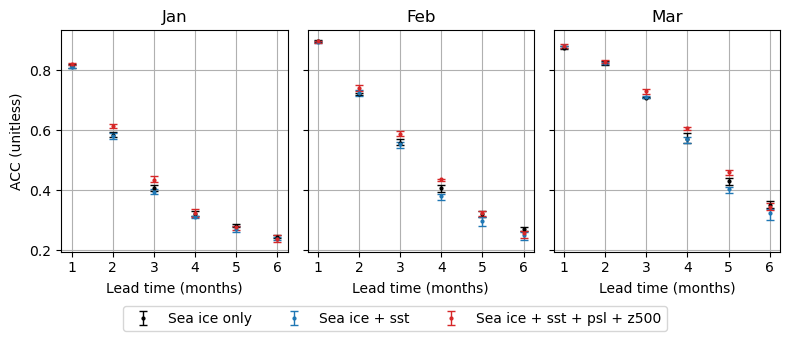

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 3.5), sharex=True, sharey=True)

x = np.arange(1, 7)
months = ["Jan", "Feb", "Mar"]

# Store one copy of handles for the legend
legend_handles = []
legend_labels = []

for i, month in enumerate([1, 2, 3]):
    mean2 = acc["input2"].sel(month=month).mean("nn_member_id")
    min2 = acc["input2"].sel(month=month).min("nn_member_id")
    max2 = acc["input2"].sel(month=month).max("nn_member_id")
    
    mean3 = acc["input3"].sel(month=month).mean("nn_member_id")
    min3 = acc["input3"].sel(month=month).min("nn_member_id")
    max3 = acc["input3"].sel(month=month).max("nn_member_id")
    
    mean4 = acc["input4"].sel(month=month).mean("nn_member_id")
    min4 = acc["input4"].sel(month=month).min("nn_member_id")
    max4 = acc["input4"].sel(month=month).max("nn_member_id")

    eb1 = axs[i].errorbar(x, mean2, 
                          yerr=[mean2 - min2, max2 - mean2], 
                          fmt='o', color='k', label="Sea ice only",
                          capsize=3, markersize=2, elinewidth=1)

    eb2 = axs[i].errorbar(x, mean3, 
                          yerr=[mean3 - min3, max3 - mean3], 
                          fmt='o', color='tab:blue', label="Sea ice + sst",
                          capsize=3, markersize=2, elinewidth=1)

    eb3 = axs[i].errorbar(x, mean4, 
                          yerr=[mean4 - min4, max4 - mean4], 
                          fmt='o', color='tab:red', label="Sea ice + sst + psl + z500",
                          capsize=3, markersize=2, elinewidth=1)

    axs[i].grid()
    axs[i].set_xticks(x)
    axs[i].set_xlabel("Lead time (months)")
    axs[i].set_title(months[i])

    # if i == 0:
    #     # Grab handles for legend from just one axis
    #     legend_handles = [eb1.lines[0], eb2.lines[0], eb3.lines[0]]
    #     legend_labels = [h.get_label() for h in legend_handles]

axs[0].set_ylabel("ACC (unitless)")

handles = [eb1, eb2, eb3]
labels = [h.get_label() for h in handles]

fig.tight_layout(rect=[0, 0.1, 1, 1])
fig.legend(handles, labels, loc="lower center", ncol=3, bbox_to_anchor=(0.5, 0.02))

plt.savefig("figures/cesm/exp1_ACC_diff_inputs_with_error_points.jpg", dpi=300, bbox_inches="tight")


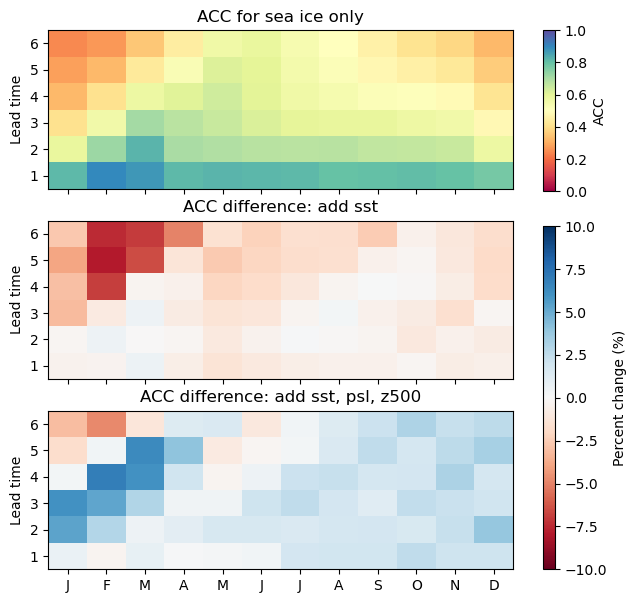

In [27]:

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,7), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

acc_input2 = acc["input2"].mean("nn_member_id")
acc_input3 = acc["input3"].mean("nn_member_id")
acc_input4 = acc["input4"].mean("nn_member_id")

cax = axs[0].pcolormesh(x, y, acc_input2, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title(f"ACC for sea ice only")

cax2 = axs[1].pcolormesh(x, y, 100 * (acc_input3 - acc_input2) / acc_input2, cmap='RdBu', shading='flat', vmin=-10, vmax=10)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("ACC difference: add sst")

axs[2].pcolormesh(x, y, 100 * (acc_input4 - acc_input2) / acc_input2, cmap='RdBu', shading='flat', vmin=-10, vmax=10)
axs[2].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2].set_ylabel("Lead time")
axs[2].set_title("ACC difference: add sst, psl, z500")


cbar_ax = fig.add_axes([0.95, 0.65, 0.02, 0.23])
cbar_ax2 = fig.add_axes([0.95, 0.11, 0.02, 0.49])
plt.colorbar(cax, cax=cbar_ax, label=r'ACC', orientation='vertical')
plt.colorbar(cax2, cax=cbar_ax2, label=r'Percent change (%)', orientation='vertical')
plt.savefig("figures/cesm/exp1_ACC_diff_inputs_percent.jpg", dpi=300, bbox_inches='tight')

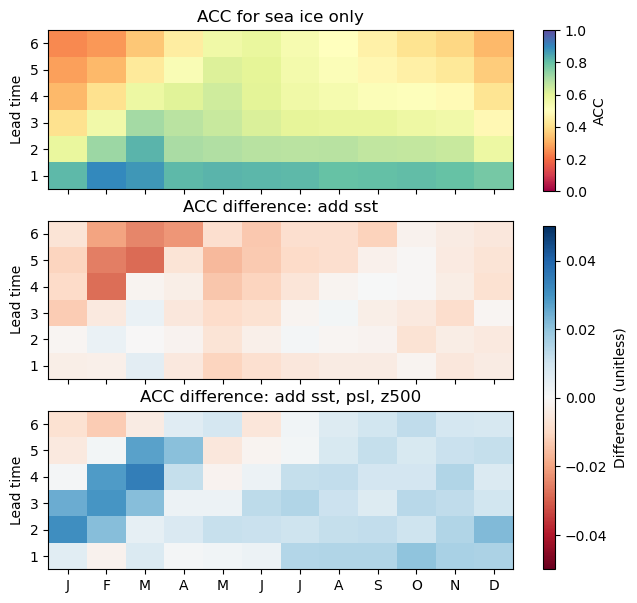

In [70]:

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,7), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

cax = axs[0].pcolormesh(x, y, acc_input2, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title(f"ACC for sea ice only")

cax2 = axs[1].pcolormesh(x, y, (acc_input3 - acc_input2), cmap='RdBu', shading='flat', vmin=-0.05, vmax=0.05)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("ACC difference: add sst")

axs[2].pcolormesh(x, y, (acc_input4 - acc_input2), cmap='RdBu', shading='flat', vmin=-0.05, vmax=0.05)
axs[2].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2].set_ylabel("Lead time")
axs[2].set_title("ACC difference: add sst, psl, z500")


cbar_ax = fig.add_axes([0.95, 0.65, 0.02, 0.23])
cbar_ax2 = fig.add_axes([0.95, 0.11, 0.02, 0.49])
plt.colorbar(cax, cax=cbar_ax, label=r'ACC', orientation='vertical')
plt.colorbar(cax2, cax=cbar_ax2, label=r'Difference (unitless)', orientation='vertical')
plt.savefig("figures/cesm/exp1_ACC_diff_inputs.jpg", dpi=300, bbox_inches='tight')